# Rare Variant Analysis

In this notebook, I'm going to analyze the rare variants identified
in the Rare Variant Processing notebook.

In [1]:
import copy
import cPickle
import datetime as dt
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
from ipyparallel import Client
from scipy.stats import fisher_exact
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyencodetools as pet
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import socket
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
genes = pbt.BedTool(cpy.gencode_gene_bed)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
log_tpm = np.log10(tpm + 1)

cnvs = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data',
                                  'cnvs.tsv'), index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
unr_rna_meta = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'peer_10_residuals.tsv')
residuals = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)
ase_pval = ase_pval[rna_meta[rna_meta.in_eqtl].index]
ase_pval.columns = rna_meta[rna_meta.in_eqtl].wgs_id

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

In [5]:
fn = os.path.join(ciepy.root, 'private_output', 
                  'rare_variant_processing', 'promoter_dhs_variants.pickle')
variants = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output', 
                  'rare_variant_processing', 'promoter_dhs_genotypes.tsv')
genotypes = pd.read_table(fn, index_col=0)
# fn = os.path.join(ciepy.root, 'private_output', 
#                   'rare_variant_processing', 'tf_disruption.tsv')
# tf_disruption = pd.read_table(fn, index_col=0)

In [6]:
unrelateds = unr_rna_meta

In [7]:
variants.shape

(284025, 25)

I'll remove variants whose minor allele wasn't in the unrelateds
or that weren't called in at least 100 of the unrelateds.

In [8]:
variants_f = variants[variants.unr_mac > 0]
variants_f = variants_f[variants_f.unr_called >= 100]
variants_f.shape

(234529, 25)

I'm trying to decide on the definition of rare. There are 284,025 promoter
DHS variants. Here are the number of 1,000 Genomes populations below 0.5% for each
variant:

In [9]:
(variants_f[[x for x in variants_f.columns if '_AF' in x]] < 0.005).sum(axis=1).value_counts()

5    100358
0     54222
4     32804
3     22000
1     12788
2     12357
dtype: int64

This is what it looks like if we remove variants that aren't in 1KGP.

In [10]:
tdf = variants_f[variants_f.AF != 0]
(tdf[[x for x in tdf.columns if '_AF' in x]] < 0.005).sum(axis=1).value_counts()

5    58426
0    54222
4    32804
3    22000
1    12788
2    12357
dtype: int64

Let's keep variants with MAF less than 0.5% in 1KGP.

In [11]:
variants_f = variants_f[variants_f.AF <= 0.005]
variants_f.shape

(126820, 25)

This is the number of alleles observed in my unrelateds:

In [12]:
variants_f.unr_mac.value_counts().head(10)

1     85267
2     13901
3      5407
4      2792
5      1615
6      1117
7       765
9       590
8       555
10      479
Name: unr_mac, dtype: int64

And this is the minor allele frequency:

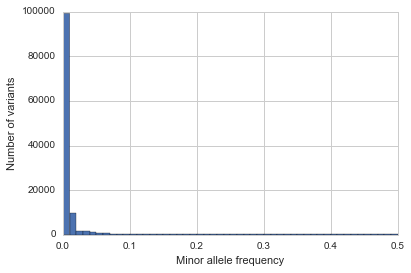

In [13]:
variants_f['unr_maf'] = (variants_f.unr_mac / (variants_f.unr_called * 2.))
variants_f.unr_maf.hist(bins=np.arange(0, 0.51, 0.01))
plt.ylabel('Number of variants')
plt.xlabel('Minor allele frequency');

There are some variants that I see at a higher frequency but most are rare. I'm going
to keep things whose minor allele count is one.

In [14]:
variants_f = variants_f[variants_f.unr_mac == 1]
variants_f.shape

(85267, 26)

In [15]:
sum([len(x & set(residuals.index)) > 0 for x in variants_f.genes])

65552

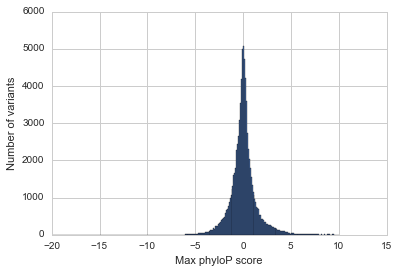

In [16]:
variants_f.max_phyloP100way.hist(bins=np.arange(-20, 10.1, 0.1))
plt.xlabel('Max phyloP score')
plt.ylabel('Number of variants');

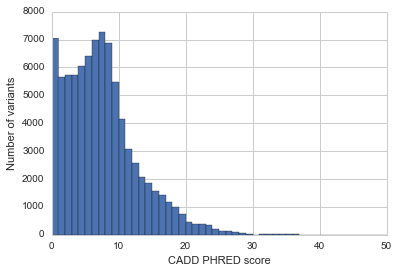

In [17]:
variants_f.cadd_phred.hist(bins=np.arange(0, 51))
plt.ylabel('Number of variants')
plt.xlabel('CADD PHRED score');

In [18]:
def stratify_on_rare(variants, genotypes, exp, ase_pvals):
    rare_ind = []
    rare = {}
    #for k in ['zscore', 'sample', 'position', 'tf_disrupt', 'ase_pval']:
    for k in ['exp', 'sample', 'position', 'ase_pval']:
        rare[k] = []
    not_rare_ind = []
    not_rare = {}
    for k in ['exp', 'sample', 'position', 'ase_pval']:
        not_rare[k] = []

    for i,ind in enumerate(variants.index):
        se = genotypes.ix[ind].dropna()
        mode = se.mode().values[0]
        rare_samples = se[se != mode].index
        not_rare_samples = se[se == mode].index
        genes = variants.ix[ind, 'genes']
        for g in genes:
            if g in exp.index:
                rare['exp'] += list(exp.ix[g, rare_samples])
                rare['sample'] += list(rare_samples)
                rare['position'] += [ind for i in range(len(rare_samples))]
                #rare['tf_disrupt'] += [rare_vars.ix[ind, 'tf_disrupt'] for i in range(len(rare_samples))]
                if g in ase_pvals.index:
                    rare['ase_pval'] += list(ase_pvals.ix[g, rare_samples])
                else:
                    rare['ase_pval'] += [np.nan for i in range(len(rare_samples))]
                rare_ind += ['{}:{}'.format(ind, x) for x in rare_samples]

                not_rare['exp'] += list(exp.ix[g, not_rare_samples])
                not_rare['sample'] += list(not_rare_samples)
                not_rare['position'] += [ind for i in range(len(not_rare_samples))]
                if g in ase_pvals.index:
                    not_rare['ase_pval'] += list(ase_pvals.ix[g, not_rare_samples])
                else:
                    not_rare['ase_pval'] += [np.nan for i in range(len(not_rare_samples))]
                not_rare_ind += ['{}:{}'.format(ind, x) for x in not_rare_samples]
    rare_info = pd.DataFrame(rare, index=rare_ind)
    not_rare_info = pd.DataFrame(not_rare, index=not_rare_ind)
    return rare_info, not_rare_info

def summarize_stratification(rare_info, not_rare_info):
    r = sum(rare_info.ase_pval.dropna() < 0.005) / float(rare_info.ase_pval.dropna().shape[0])
    nr = sum(not_rare_info.ase_pval.dropna() < 0.005) / float(not_rare_info.ase_pval.dropna().shape[0])
    a = (rare_info.ase_pval.dropna() < 0.005).value_counts()
    b = (not_rare_info.ase_pval.dropna() < 0.005).value_counts()
    odds, p = stats.fisher_exact([[a[True], a[False]], [b[True], b[False]]])
    print('Gene/samples with rare promoter DHS variant have ASE {:.2f}% of the '
          'time while gene/samples without rare promoter DHS variant have ASE '
          '{:.2f}% of the time (odds={:.2f}, p={:.2e}, Fisher exact).\n'.format(r * 100, nr * 100, odds, p))

    s,p = stats.mannwhitneyu(rare_info.exp, not_rare_info.exp)
    print('Mann Whitney U for distributions of expression values for genes with and without '
          'rare promoter DHS variants: p={:.2e}.\n'.format(p))

    s,p = stats.mannwhitneyu(rare_info.exp.abs(), not_rare_info.exp.abs())
    print('Mann Whitney U for distributions of expression magnitudes for genes with and without '
          'rare promoter DHS variants: p={:.2e}.\n'.format(p))

    weights = np.ones_like(not_rare_info.exp) / float(not_rare_info.shape[0])
    m = np.floor(min(not_rare_info.exp.min(), rare_info.exp.min()))
    not_rare_info.exp.hist(bins=np.arange(m, abs(m) + 0.2, 0.2), 
                           alpha=0.5, histtype='stepfilled', 
                           label='not rare $n={}$'.format(not_rare_info.shape[0]),
                           weights=weights)
    weights = np.ones_like(rare_info.exp) / float(rare_info.shape[0])
    rare_info.exp.hist(bins=np.arange(m, abs(m) + 0.2, 0.2), 
                       alpha=0.5, histtype='stepfilled', 
                       label='rare $n={}$'.format(rare_info.shape[0]),
                       weights=weights)
    plt.legend()
    plt.xlabel('Expression')
    plt.ylabel('Fraction of gene/sample pairs');
    
def make_pdfs_cdfs(rare_info, not_rare_info):
    # Make PDFs
    m = np.floor(rare_info.exp.min())
    pdfs = pd.DataFrame(index=np.arange(m, abs(m) + 0.1, 0.1))
    density = scipy.stats.gaussian_kde(rare_info.exp)
    pdfs['rare'] = density(pdfs.index)
    density = scipy.stats.gaussian_kde(not_rare_info.exp)
    pdfs['not_rare'] = density(pdfs.index)
    
    fig,axs = plt.subplots(1, 2, figsize=(10, 4))
    ax = axs[0]

    # Plot PDFs
    pdfs.rare.plot(label='rare', ax=ax)
    pdfs.not_rare.plot(label='not rare', ax=ax)
    ax.legend()
    ax.set_ylabel('Fraction of genes')
    ax.set_xlabel('Expression')
    ax = axs[1]
    (pdfs.rare - pdfs.not_rare).plot(ax=ax)
    ax.set_ylabel('$\Delta$ fraction of genes')
    ax.set_xlabel('Expression')
    fig.tight_layout()
    
    # Make CDFs
    cdfs = pd.DataFrame(index=pdfs.index)
    area = [0]
    for i in range(1, cdfs.shape[0]):
        area.append(0.5 * (pdfs['rare'].loc[pdfs.index[i - 1]] + pdfs['rare'][pdfs.index[i]]) * 0.1)
    cdfs['rare'] = pd.Series(area, index=cdfs.index).cumsum()
    area = [0]
    for i in range(1, cdfs.shape[0]):
        area.append(0.5 * (pdfs['not_rare'].loc[pdfs.index[i - 1]] + pdfs['not_rare'][pdfs.index[i]]) * 0.1)
    cdfs['not_rare'] = pd.Series(area, index=cdfs.index).cumsum()
    
    # Plot CDFs
    cdfs.plot()
    plt.xlabel('Expression')
    plt.ylabel('Probability');
    
    return pdfs, cdfs

In [19]:
residuals_c = (residuals.T - residuals.mean(axis=1)).T
residuals_z = (residuals_c.T / residuals_c.std(axis=1)).T

## European unrelateds

I want to start by looking at just Europeans.

In [20]:
euro_unrelateds = unrelateds.ix[(subject_meta.ix[unrelateds.subject_id, 'ethnicity_group'] == 
                                 'European').values]
t = genotypes.ix[variants_f.index, euro_unrelateds.wgs_id]
euro_variants_f = variants_f.ix[t[t.sum(axis=1) > 0].index]

In [21]:
a = os.path.join(private_outdir, 'euro_rare_variants_info.tsv')
b = os.path.join(private_outdir, 'euro_not_rare_variants_info.tsv.gz')
if not os.path.exists(a) and not os.path.exists(b):
    euro_rare_info, euro_not_rare_info = stratify_on_rare(
        euro_variants_f,
        genotypes[euro_unrelateds.wgs_id], 
        residuals_z[euro_unrelateds.wgs_id],
        ase_pval[euro_unrelateds.wgs_id])
    euro_rare_info['cadd_phred'] = variants_f.ix[euro_rare_info.position, 'cadd_phred'].values
    euro_rare_info['max_phyloP100way'] = variants_f.ix[euro_rare_info.position, 'max_phyloP100way'].values
    euro_rare_info.to_csv(a, sep='\t')
    euro_not_rare_info.to_csv(b, sep='\t', compression='gzip')
else:
    euro_rare_info = pd.read_table(a, index_col=0)
    euro_not_rare_info = pd.read_table(b, index_col=0)

Gene/samples with rare promoter DHS variant have ASE 3.57% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=1.28, p=1.21e-08, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=4.76e-03.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=9.28e-09.



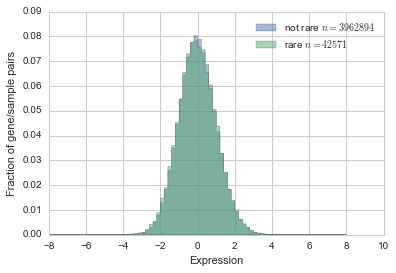

In [22]:
summarize_stratification(euro_rare_info, euro_not_rare_info)

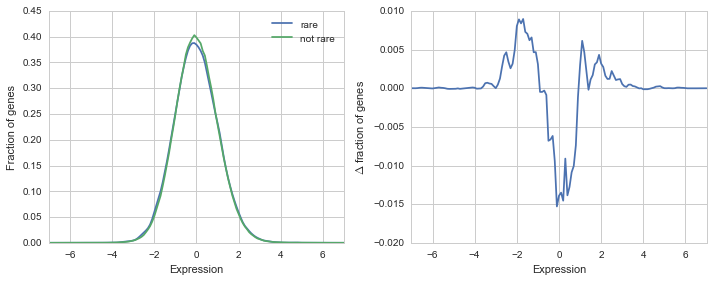

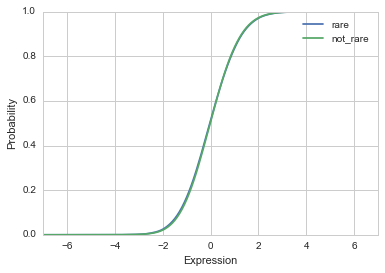

In [23]:
all_pdfs,all_cdfs = make_pdfs_cdfs(euro_rare_info, euro_not_rare_info)

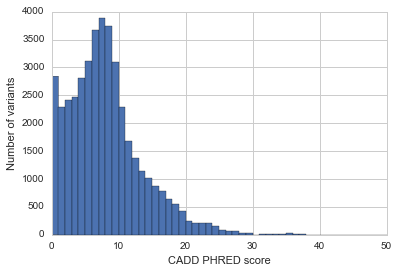

In [24]:
euro_rare_info.cadd_phred.hist(bins=np.arange(51))
plt.ylabel('Number of variants')
plt.xlabel('CADD PHRED score');

Gene/samples with rare promoter DHS variant have ASE 3.73% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=1.34, p=1.95e-04, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=7.27e-04.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=1.62e-12.



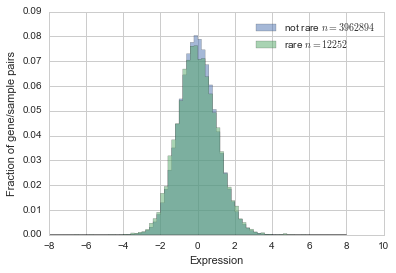

In [25]:
summarize_stratification(euro_rare_info[euro_rare_info.cadd_phred >= 10], euro_not_rare_info)

Gene/samples with rare promoter DHS variant have ASE 3.64% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=1.30, p=2.02e-01, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=4.25e-04.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=4.58e-05.



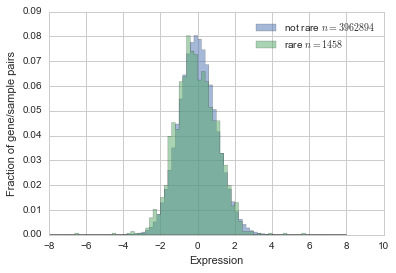

In [26]:
summarize_stratification(euro_rare_info[euro_rare_info.cadd_phred >= 20], euro_not_rare_info)

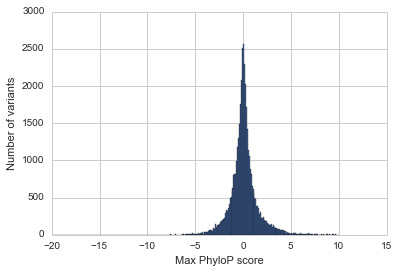

In [27]:
euro_rare_info.max_phyloP100way.hist(bins=np.arange(-20, 10.1, 0.1))
plt.ylabel('Number of variants')
plt.xlabel('Max PhyloP score');

Gene/samples with rare promoter DHS variant have ASE 3.57% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=1.28, p=1.42e-02, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=6.24e-03.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=3.54e-10.



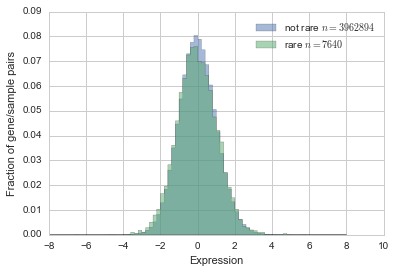

In [28]:
summarize_stratification(euro_rare_info[euro_rare_info.max_phyloP100way >= 1], euro_not_rare_info)

Gene/samples with rare promoter DHS variant have ASE 5.10% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=1.85, p=4.77e-04, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=1.50e-02.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=6.34e-06.



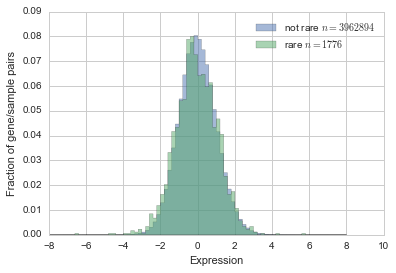

In [29]:
summarize_stratification(euro_rare_info[euro_rare_info.max_phyloP100way >= 3], euro_not_rare_info)

Gene/samples with rare promoter DHS variant have ASE 3.85% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=1.38, p=3.00e-01, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=1.60e-01.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=3.62e-04.



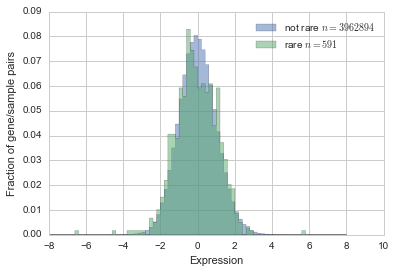

In [30]:
summarize_stratification(euro_rare_info[(euro_rare_info.max_phyloP100way >= 3) &
                                        (euro_rare_info.cadd_phred > 20)], euro_not_rare_info)

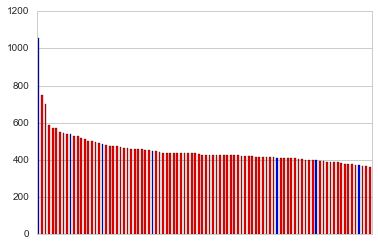

In [31]:
vc = euro_rare_info['sample'].value_counts()
c = pd.Series(['red', 'blue'], index=['Blood', 'Fibroblast'])[wgs_meta.ix[vc.index, 'cell']]
vc.plot(kind='bar', color=c)
plt.xticks([]);

In [32]:
wgs_meta.ix[euro_rare_info['sample'].value_counts().head().index]

,cell,subject_id
63968319-c83a-460c-bcb0-c74f13309332,Fibroblast,d6646110-a6f3-4176-bf1a-92a51ed6f4bc
6578eed0-d583-4065-b30c-f0814dff2b00,Blood,7ecf080d-4d17-4023-b024-85a5942d55fe
ee74dfab-5fc6-406c-9171-3556551519e3,Blood,1dd9eacc-e3d3-4d60-9dcb-60a17808cde9
8777ffb1-3164-497e-b105-2895c1bd05cc,Blood,fabb1fba-dea1-44a5-a9c2-e40b46011c7a
78d8c099-465b-412d-bf88-e7ae54366e34,Blood,03346cae-a4f3-4481-92ff-d76db0c82468


In [33]:
euro_rare_info['sample'].value_counts().head()

63968319-c83a-460c-bcb0-c74f13309332    1055
6578eed0-d583-4065-b30c-f0814dff2b00     749
ee74dfab-5fc6-406c-9171-3556551519e3     700
8777ffb1-3164-497e-b105-2895c1bd05cc     588
78d8c099-465b-412d-bf88-e7ae54366e34     571
Name: sample, dtype: int64

## All unrelateds

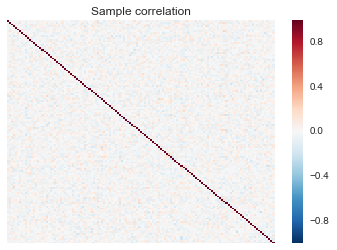

In [34]:
std = residuals.std(axis=1)
std.sort_values(inplace=True, ascending=False)
rc = residuals_z.ix[std.head(500).index, unrelateds.wgs_id].corr()
sns.heatmap(rc, xticklabels=[], yticklabels=[])
plt.title('Sample correlation');

The samples aren't really correlated in any meaningful way after PEER,
so I think I can use samples from different ancestries.

In [35]:
a = os.path.join(private_outdir, 'all_rare_variants_info.tsv')
b = os.path.join(private_outdir, 'all_not_rare_variants_info.tsv.gz')
if not os.path.exists(a) and not os.path.exists(b):
    all_rare_info, all_not_rare_info = stratify_on_rare(
        variants_f, 
        genotypes[unrelateds.wgs_id], 
        residuals_z[unrelateds.wgs_id],
        ase_pval[unrelateds.wgs_id])
    all_rare_info['cadd_phred'] = variants_f.ix[all_rare_info.position, 'cadd_phred'].values
    all_rare_info['max_phyloP100way'] = variants_f.ix[all_rare_info.position, 'max_phyloP100way'].values
    all_rare_info.to_csv(a, sep='\t')
    all_not_rare_info.to_csv(b, sep='\t', compression='gzip')
else:
    all_rare_info = pd.read_table(a, index_col=0)
    all_not_rare_info = pd.read_table(b, index_col=0)

In [36]:
len(set(all_rare_info.position))

65552

In [37]:
all_rare_info.shape

(74242, 6)

In [38]:
all_not_rare_info.shape

(9649539, 4)

Gene/samples with rare promoter DHS variant have ASE 3.55% of the time while gene/samples without rare promoter DHS variant have ASE 2.90% of the time (odds=1.23, p=7.60e-11, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=2.11e-05.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=9.87e-11.



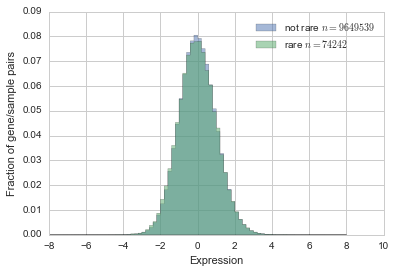

In [39]:
summarize_stratification(all_rare_info, all_not_rare_info)

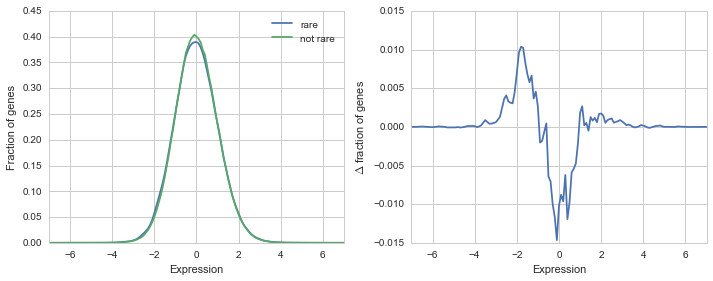

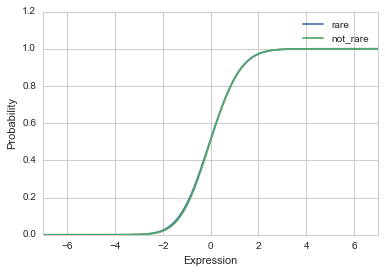

In [40]:
all_pdfs,all_cdfs = make_pdfs_cdfs(all_rare_info, all_not_rare_info)

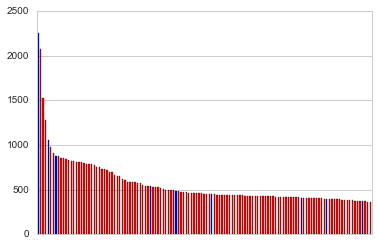

In [41]:
vc = all_rare_info['sample'].value_counts()
c = pd.Series(['red', 'blue'], index=['Blood', 'Fibroblast'])[wgs_meta.ix[vc.index, 'cell']]
vc.plot(kind='bar', color=c)
plt.xticks([]);

In [42]:
stats.spearmanr(all_rare_info.exp.abs(), all_rare_info.cadd_phred)

SpearmanrResult(correlation=0.0093944659157980098, pvalue=0.010474456300213061)

In [43]:
stats.spearmanr(all_rare_info.exp.abs(), all_rare_info.max_phyloP100way)

SpearmanrResult(correlation=0.014508279710166085, pvalue=7.7090898019766034e-05)

Gene/samples with rare promoter DHS variant have ASE 3.68% of the time while gene/samples without rare promoter DHS variant have ASE 2.90% of the time (odds=1.28, p=3.07e-05, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=3.52e-05.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=8.08e-13.



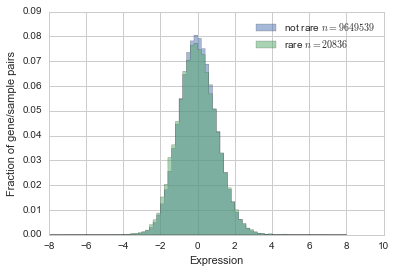

In [44]:
summarize_stratification(all_rare_info[all_rare_info.cadd_phred >= 10], all_not_rare_info)

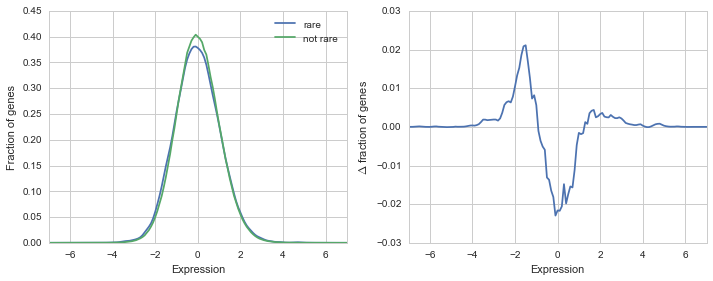

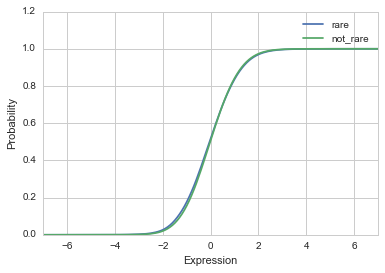

In [45]:
all_pdfs,all_cdfs = make_pdfs_cdfs(all_rare_info[all_rare_info.cadd_phred >= 10], all_not_rare_info)

Gene/samples with rare promoter DHS variant have ASE 4.66% of the time while gene/samples without rare promoter DHS variant have ASE 2.90% of the time (odds=1.64, p=1.01e-03, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=2.33e-05.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=7.06e-06.



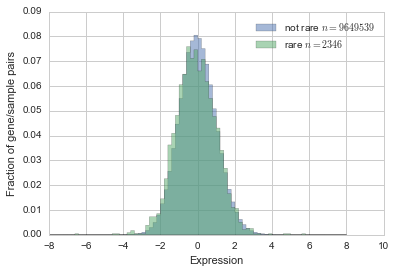

In [46]:
summarize_stratification(all_rare_info[all_rare_info.cadd_phred >= 20], all_not_rare_info)

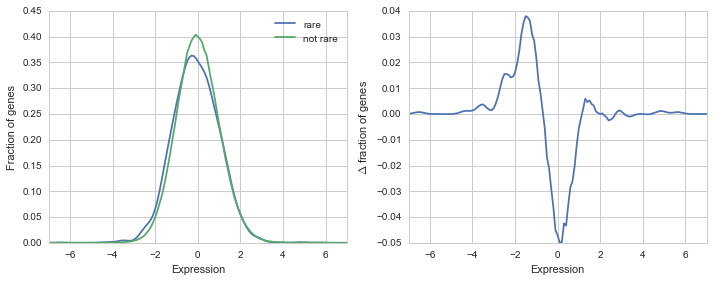

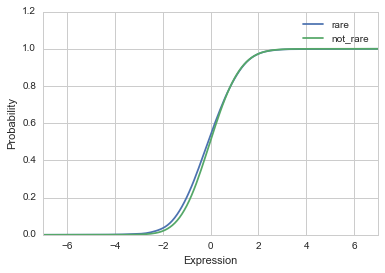

In [47]:
all_pdfs,all_cdfs = make_pdfs_cdfs(all_rare_info[all_rare_info.cadd_phred >= 20], all_not_rare_info)

Gene/samples with rare promoter DHS variant have ASE 3.55% of the time while gene/samples without rare promoter DHS variant have ASE 2.90% of the time (odds=1.23, p=6.67e-03, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=6.90e-06.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=6.45e-12.



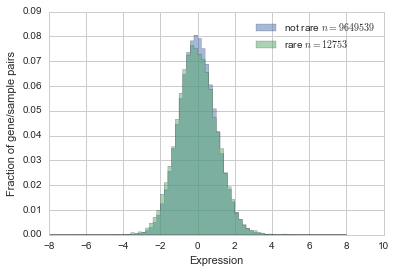

In [48]:
summarize_stratification(all_rare_info[all_rare_info.max_phyloP100way >= 1], all_not_rare_info)

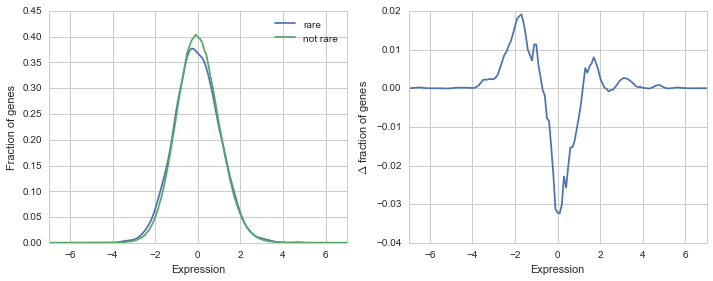

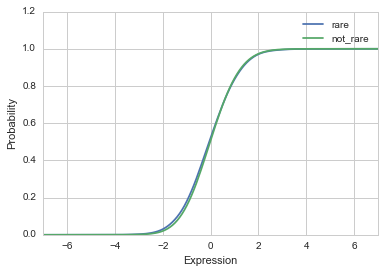

In [49]:
all_pdfs,all_cdfs = make_pdfs_cdfs(all_rare_info[all_rare_info.max_phyloP100way >= 1], all_not_rare_info)

Gene/samples with rare promoter DHS variant have ASE 4.83% of the time while gene/samples without rare promoter DHS variant have ASE 2.90% of the time (odds=1.70, p=1.63e-04, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=1.28e-04.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=1.18e-06.



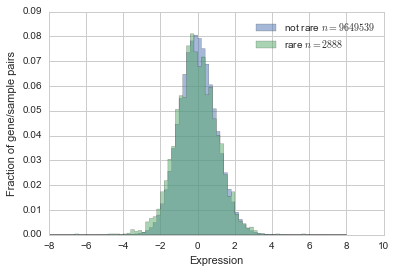

In [50]:
summarize_stratification(all_rare_info[all_rare_info.max_phyloP100way >= 3], all_not_rare_info)

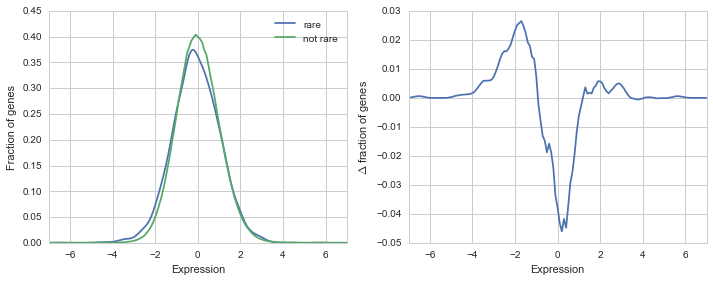

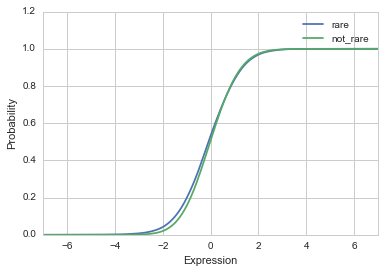

In [51]:
all_pdfs,all_cdfs = make_pdfs_cdfs(all_rare_info[all_rare_info.max_phyloP100way >= 3], all_not_rare_info)

## Rare CNVs

In [52]:
fn = os.path.join(ciepy.root, 'private_output', 'rare_variant_processing', 'rare_cnvs.pickle')
rare_cnv_info = cPickle.load(open(fn))

In [53]:
cnv_rare = {}
for k in ['exp', 'gene', 'sample', 'name', 'ase_pval', 'overlaps_exon', 'contains_gene']:
    cnv_rare[k] = []
cnv_not_rare = {}
for k in ['exp', 'gene', 'sample', 'name', 'ase_pval']:
    cnv_not_rare[k] = []
rare_cnv_info['exp'] = np.nan
rare_cnv_info['ase_pval'] = np.nan
for i in rare_cnv_info.index:
    s = rare_cnv_info.ix[i, 'sample']
    genes = rare_cnv_info.ix[i, 'overlaps_gene']
    for g in genes:
        if g in residuals_z.index:
            cnv_rare['exp'].append(residuals_z.ix[g, s])
            cnv_rare['gene'].append(g)
            cnv_rare['sample'].append(s)
            cnv_rare['name'].append(i)
            if type(rare_cnv_info.ix[i, 'overlaps_gene_exon']) == set:
                cnv_rare['overlaps_exon'].append(g in rare_cnv_info.ix[i, 'overlaps_gene_exon'])
            else:
                cnv_rare['overlaps_exon'].append(False)
            if type(rare_cnv_info.ix[i, 'contains_gene']) == set:
                cnv_rare['contains_gene'].append(g in rare_cnv_info.ix[i, 'contains_gene'])
            else:
                cnv_rare['contains_gene'].append(False)
            
            nr = list(set(unrelateds.wgs_id) - set([s]))
            cnv_not_rare['exp'] += list(residuals_z.ix[g, nr])
            cnv_not_rare['gene'] += [g] * len(nr)
            cnv_not_rare['sample'] += nr
            cnv_not_rare['name'] += [i] * len(nr)
            if g in ase_pval.index:
                cnv_rare['ase_pval'].append(ase_pval.ix[g, s])
                cnv_not_rare['ase_pval'] += list(ase_pval.ix[g, nr])
            else:
                cnv_rare['ase_pval'].append(np.nan)
                cnv_not_rare['ase_pval'] += [np.nan] * len(nr)

cnv_rare = pd.DataFrame(cnv_rare)
cnv_not_rare = pd.DataFrame(cnv_not_rare)
cnv_rare['svtype'] = rare_cnv_info.ix[cnv_rare.name, 'svtype'].values

Gene/samples with rare promoter DHS variant have ASE 6.71% of the time while gene/samples without rare promoter DHS variant have ASE 2.82% of the time (odds=2.48, p=2.40e-13, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=3.48e-01.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=2.13e-38.



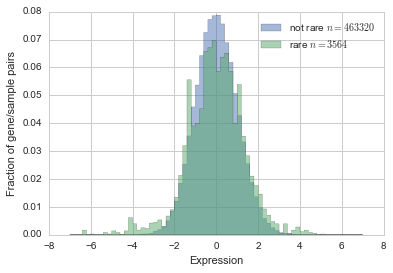

In [54]:
summarize_stratification(cnv_rare, cnv_not_rare)

Gene/samples with rare promoter DHS variant have ASE 24.17% of the time while gene/samples without rare promoter DHS variant have ASE 2.57% of the time (odds=12.06, p=2.25e-33, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=3.06e-08.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=8.05e-29.



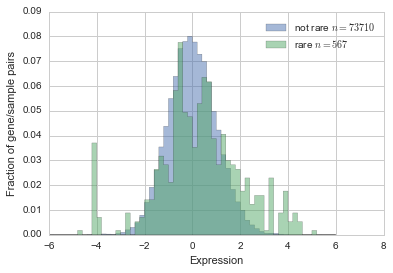

In [55]:
r = cnv_rare[cnv_rare.svtype == 'DUP']
nr = cnv_not_rare[cnv_not_rare.name.apply(lambda x: x in r.name.values)]
summarize_stratification(r, nr)

Gene/samples with rare promoter DHS variant have ASE 26.80% of the time while gene/samples without rare promoter DHS variant have ASE 2.30% of the time (odds=15.54, p=4.33e-20, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=3.12e-13.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=8.13e-21.



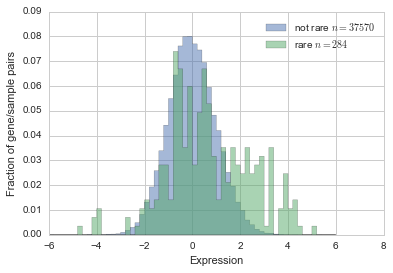

In [56]:
r = cnv_rare[(cnv_rare.svtype == 'DUP') & (cnv_rare.overlaps_exon)]
nr = cnv_not_rare[cnv_not_rare.name.apply(lambda x: x in r.name.values)]
summarize_stratification(r, nr)

Gene/samples with rare promoter DHS variant have ASE 3.49% of the time while gene/samples without rare promoter DHS variant have ASE 2.86% of the time (odds=1.23, p=2.12e-01, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=2.62e-03.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=1.04e-20.



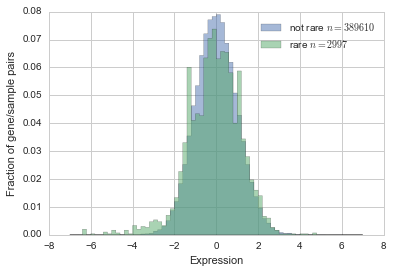

In [57]:
r = cnv_rare[cnv_rare.svtype == 'DEL']
nr = cnv_not_rare[cnv_not_rare.name.apply(lambda x: x in r.name.values)]
summarize_stratification(r, nr)

Gene/samples with rare promoter DHS variant have ASE 6.53% of the time while gene/samples without rare promoter DHS variant have ASE 4.33% of the time (odds=1.54, p=1.12e-01, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=5.17e-13.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=3.31e-27.



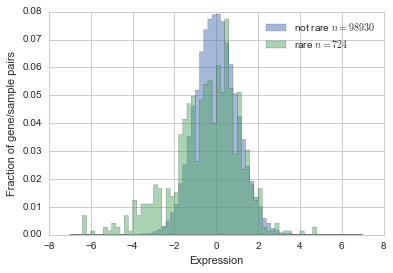

In [58]:
r = cnv_rare[(cnv_rare.svtype == 'DEL') & (cnv_rare.overlaps_exon)]
nr = cnv_not_rare[cnv_not_rare.name.apply(lambda x: x in r.name.values)]
summarize_stratification(r, nr)

Gene/samples with rare promoter DHS variant have ASE 28.57% of the time while gene/samples without rare promoter DHS variant have ASE 3.72% of the time (odds=10.35, p=2.64e-02, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=1.62e-01.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=1.87e-03.



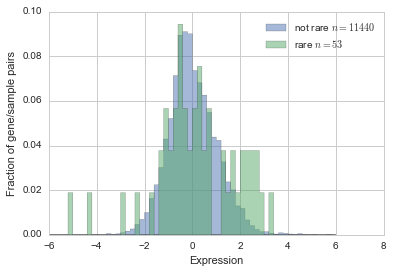

In [59]:
r = cnv_rare[cnv_rare.contains_gene]
nr = cnv_not_rare[cnv_not_rare.name.apply(lambda x: x in r.name.values)]
summarize_stratification(r, nr)

Gene/samples with rare promoter DHS variant have ASE 12.28% of the time while gene/samples without rare promoter DHS variant have ASE 3.81% of the time (odds=3.54, p=5.25e-11, Fisher exact).

Mann Whitney U for distributions of expression values for genes with and without rare promoter DHS variants: p=1.34e-02.

Mann Whitney U for distributions of expression magnitudes for genes with and without rare promoter DHS variants: p=5.58e-45.



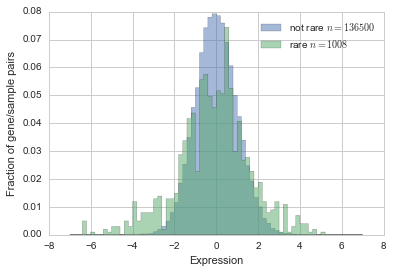

In [60]:
r = cnv_rare[cnv_rare.overlaps_exon]
nr = cnv_not_rare[cnv_not_rare.name.apply(lambda x: x in r.name.values)]
summarize_stratification(r, nr)

In [61]:
cnv_rare.to_csv(os.path.join(private_outdir, 'cnv_rare_variants_info.tsv'), sep='\t')
cnv_not_rare.to_csv(os.path.join(private_outdir, 'cnv_not_rare_variants_info.tsv'), 
                    sep='\t')